In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import lightgbm as lgbm
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, roc_auc_score
import seaborn as sns
from sklearn.model_selection import KFold
import gc

/Users/liufangfei/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
label=pd.read_csv('ID_Gender_Age_datasets.csv')
label=label.drop('Unnamed: 0',axis=1)

In [3]:
ID_list=list(label['ID'])
file_name=['AutomaticExtractionData_IMUZCenter','ManualExtractionData/IMUZCenter','ManualExtractionData/IMUZRight',
          'ManualExtractionData/IMUZLeft','ManualExtractionData/Android']
action_name=['_Walk_1','_Walk_2','_SlopeDown','_SlopeUp']

In [4]:
# max,min,mean,mean_of_max_Npersent,mean_of_min_Npersent,stand_deviation,skewtest,kurtosis,the_lenth_of_dataset
def generate_features(df,percentage):
    ls_new=[]
    ls_name=[]
    col_name=list(df.columns.values)
    for c in col_name:
        df[c]=df[c].astype('float')
        ls=list(df[c].sort_values(ascending=False))
        max_value=ls[0]
        min_value=ls[-1]
        mean_of_max_Npersent=sum(ls[:math.floor(len(ls)*percentage)])/math.floor(len(ls)*percentage)
        mean_of_min_Npersent=sum(ls[-math.floor(len(ls)*percentage):-1])/math.floor(len(ls)*percentage)
        SD=np.std(np.array(ls), ddof = 1)
        skewtest=stats.skewtest(ls)[0]
        kurtosis=stats.kurtosis(ls)
        length=len(ls)
        ls_new=ls_new+[max_value,min_value,mean_of_max_Npersent,mean_of_min_Npersent,SD,skewtest,kurtosis]  
        ls_name=ls_name+['max_value'+'_'+c,'min_value'+'_'+c,'mean_of_max_Npersent'+'_'+c,'mean_of_min_Npersent'+'_'+c,
                         'SD'+'_'+c,'skewtest'+'_'+c,'kurtosis'+'_'+c] 
    ls_new=pd.DataFrame(ls_new).T
    ls_new.columns=ls_name
    return ls_new

In [5]:
def generate_read_table(fileName,actionName,ID): 
    try:
        dataset_name= fileName + actionName
        path_name= fileName +'/'+ str(label[label['ID']==ID][dataset_name].values[0])
        if fileName=='ManualExtractionData/Android':
            df=pd.read_csv(path_name,skiprows=2)
            df.columns=[0,0,0,df.columns.values[3],df.columns.values[4],df.columns.values[5]]
            insert_line=pd.DataFrame(df.columns.values).T
            df.columns=insert_line.columns
            df=pd.concat([insert_line,df],axis=0)
        else:
            df=pd.read_csv(path_name,skiprows=2)
            insert_line=pd.DataFrame(df.columns.values).T
            df.columns=insert_line.columns
            df=pd.concat([insert_line,df],axis=0)
        df.columns=['Gx','Gy','Gz','Ax','Ay','Az']
    except:
        df=pd.DataFrame(np.zeros(6)).T
        df.columns=['Gx','Gy','Gz','Ax','Ay','Az']
    return df

In [6]:
def generate_feature_table(ID_list,label,fileName,actionName,percentage):
    df=pd.DataFrame()
    for ID in ID_list:
        try:
            data=generate_read_table(fileName,actionName,ID)
            data1=generate_features(data,percentage)
        except:
            data1=pd.DataFrame(np.zeros(42)).T
            data1.columns=df.columns
        df=df.append(data1)
    return df

In [7]:
def length_of_data(fileName,actionName,ID): 
    try:
        dataset_name= fileName + actionName
        path_name= fileName +'/'+ str(label[label['ID']==ID][dataset_name].values[0])
        df=pd.read_csv(path_name,skiprows=2)
        length=len(df)+1
    except:
        length=0
    return length

In [18]:
def kfold_lightgbm(df, num_folds, X, y):
    a=[]
    acc=[]
    kf = KFold(n_splits=num_folds)
    i=1
    feature_importance_df = pd.DataFrame()
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        LGBM=lgbm.LGBMClassifier()
        LGBM.fit(X_train, y_train)
        y_pred = LGBM.predict_proba(X_test)[:,1]
        y_pred1 = LGBM.predict(X_test)
        fpr,tpr,thresholds=roc_curve(y_test,y_pred)
        acc_score = accuracy_score(y_test,y_pred1)
        roc_auc=auc(fpr,tpr)
        a=a+ list(y_pred)
        acc=acc+ list(y_pred1)
        print('Fold %2d AUC : %.6f' % (i, roc_auc))
        print('Fold %2d ACCURACY : %.6f' % (i, acc_score))
        print('******************************************')
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = df.columns.values[:-2]
        fold_importance_df["importance"] = LGBM.feature_importances_
        fold_importance_df["fold"] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        i+=1

    fpr1,tpr1,thresholds1=roc_curve(y,a)
    print('Full AUC score %.6f' % auc(fpr1,tpr1))
    print('Full ACCURACY score %.6f' % accuracy_score(y,acc))
    return feature_importance_df

In [19]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index 
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)] 
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature",
    data=best_features.sort_values(by="importance", ascending=False)) 
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.show()

In [23]:
def prediction(ID_list,label,file_name,action_name):
    for f in file_name:
        for a in action_name:
            try:
                df=generate_feature_table(ID_list,label,f,a,0.05)
                df=df.set_index(label['ID'].values)
                label=label.set_index(label['ID'].values)
                df['Gender(0:Female;1:Male)']=label['Gender(0:Female;1:Male)']
                df['Age']=label['Age']
                y=df.values[:,-2]
                X=df.values[:,:-2]
                print('The dataset is from file: %s. The action is: %s' %(f,a[1:]))
                feature_importance_df_=kfold_lightgbm(df, 5, X, y)
                display_importances(feature_importance_df_)
            except:
                print('There is no dataset from file: %s. The action is: %s' %(f,a[1:]))

The dataset is from file: AutomaticExtractionData_IMUZCenter. The action is: Walk_1
Fold  1 AUC : 0.717756
Fold  1 ACCURACY : 0.666667
******************************************
Fold  2 AUC : 0.669344
Fold  2 ACCURACY : 0.614379
******************************************
Fold  3 AUC : 0.688737
Fold  3 ACCURACY : 0.627451
******************************************
Fold  4 AUC : 0.645303
Fold  4 ACCURACY : 0.611842
******************************************
Fold  5 AUC : 0.780979
Fold  5 ACCURACY : 0.717105
******************************************
Full AUC score 0.693578
Full ACCURACY score 0.647444


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


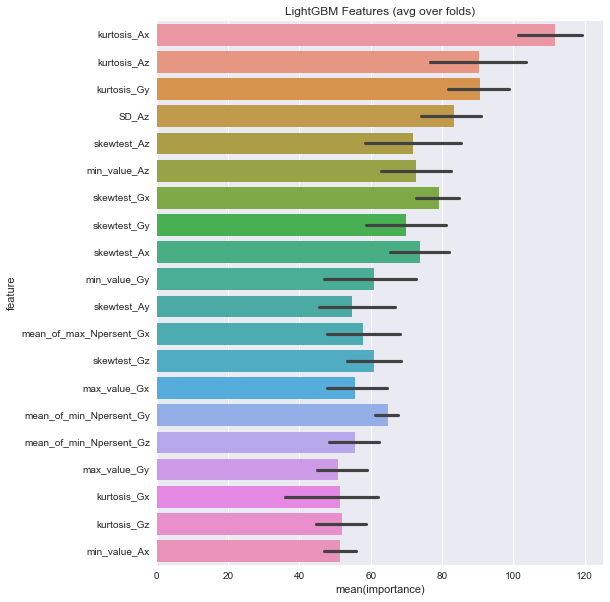

The dataset is from file: AutomaticExtractionData_IMUZCenter. The action is: Walk_2
Fold  1 AUC : 0.674478
Fold  1 ACCURACY : 0.640523
******************************************
Fold  2 AUC : 0.597232
Fold  2 ACCURACY : 0.568627
******************************************
Fold  3 AUC : 0.727699
Fold  3 ACCURACY : 0.705882
******************************************
Fold  4 AUC : 0.700088
Fold  4 ACCURACY : 0.657895
******************************************
Fold  5 AUC : 0.691967
Fold  5 ACCURACY : 0.638158
******************************************
Full AUC score 0.668498
Full ACCURACY score 0.642202


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


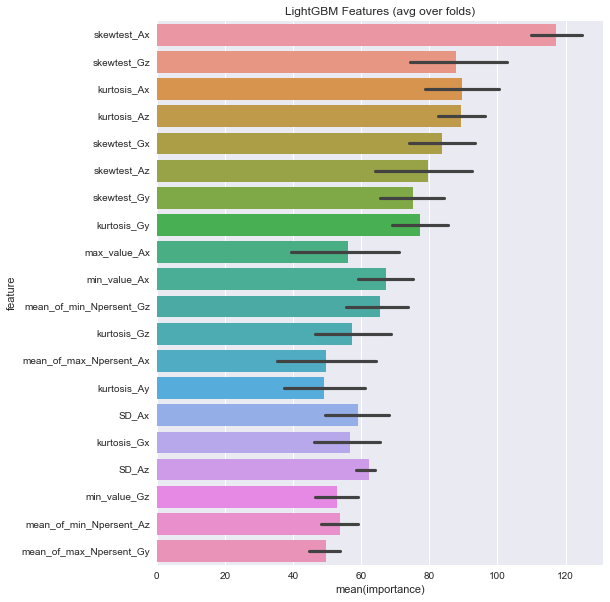

There is no dataset from file: AutomaticExtractionData_IMUZCenter. The action is: SlopeDown
There is no dataset from file: AutomaticExtractionData_IMUZCenter. The action is: SlopeUp
The dataset is from file: ManualExtractionData/IMUZCenter. The action is: Walk_1
Fold  1 AUC : 0.652583
Fold  1 ACCURACY : 0.614379
******************************************
Fold  2 AUC : 0.569549
Fold  2 ACCURACY : 0.535948
******************************************
Fold  3 AUC : 0.695158
Fold  3 ACCURACY : 0.627451
******************************************
Fold  4 AUC : 0.654873
Fold  4 ACCURACY : 0.546053
******************************************
Fold  5 AUC : 0.774792
Fold  5 ACCURACY : 0.750000
******************************************
Full AUC score 0.652762
Full ACCURACY score 0.614679


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


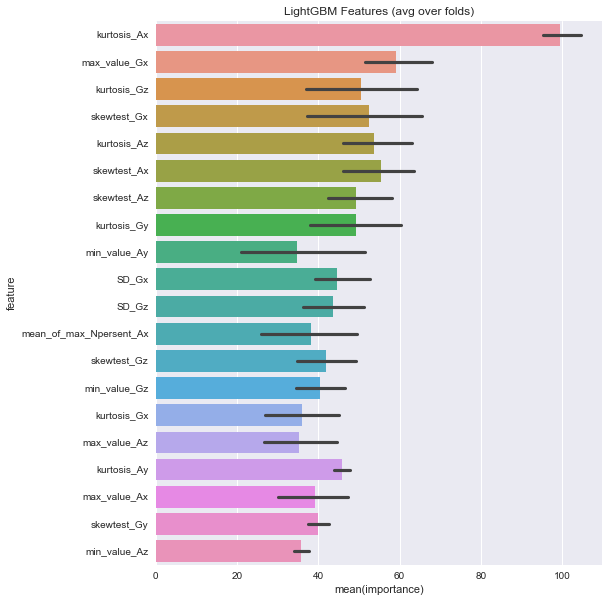

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: Walk_2
Fold  1 AUC : 0.589719
Fold  1 ACCURACY : 0.549020
******************************************
Fold  2 AUC : 0.630041
Fold  2 ACCURACY : 0.562092
******************************************
Fold  3 AUC : 0.630337
Fold  3 ACCURACY : 0.568627
******************************************
Fold  4 AUC : 0.741879
Fold  4 ACCURACY : 0.664474
******************************************
Fold  5 AUC : 0.789935
Fold  5 ACCURACY : 0.750000
******************************************
Full AUC score 0.667417
Full ACCURACY score 0.618611


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


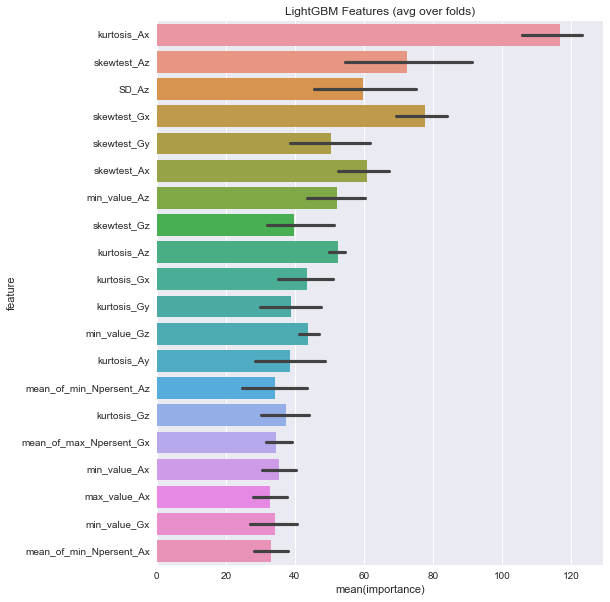

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: SlopeDown
Fold  1 AUC : 0.638043
Fold  1 ACCURACY : 0.620915
******************************************
Fold  2 AUC : 0.528195
Fold  2 ACCURACY : 0.522876
******************************************
Fold  3 AUC : 0.641270
Fold  3 ACCURACY : 0.594771
******************************************
Fold  4 AUC : 0.762774
Fold  4 ACCURACY : 0.651316
******************************************
Fold  5 AUC : 0.754017
Fold  5 ACCURACY : 0.717105
******************************************
Full AUC score 0.660807
Full ACCURACY score 0.621232


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


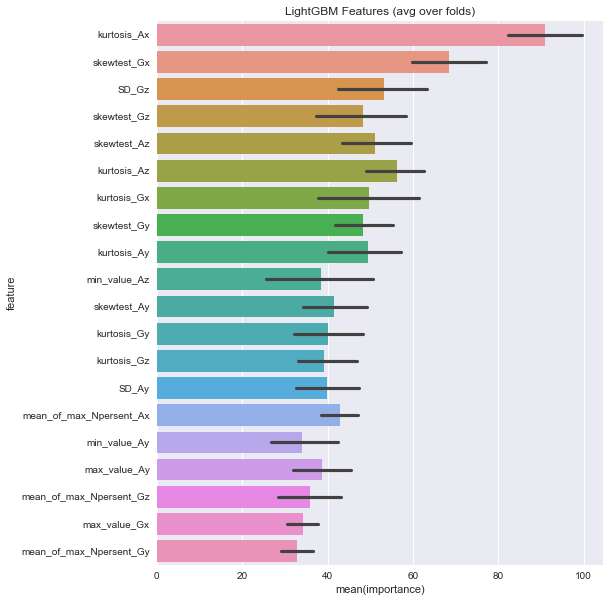

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: SlopeUp
Fold  1 AUC : 0.707321
Fold  1 ACCURACY : 0.653595
******************************************
Fold  2 AUC : 0.613807
Fold  2 ACCURACY : 0.562092
******************************************
Fold  3 AUC : 0.588511
Fold  3 ACCURACY : 0.549020
******************************************
Fold  4 AUC : 0.714486
Fold  4 ACCURACY : 0.618421
******************************************
Fold  5 AUC : 0.663712
Fold  5 ACCURACY : 0.552632
******************************************
Full AUC score 0.647415
Full ACCURACY score 0.587156


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


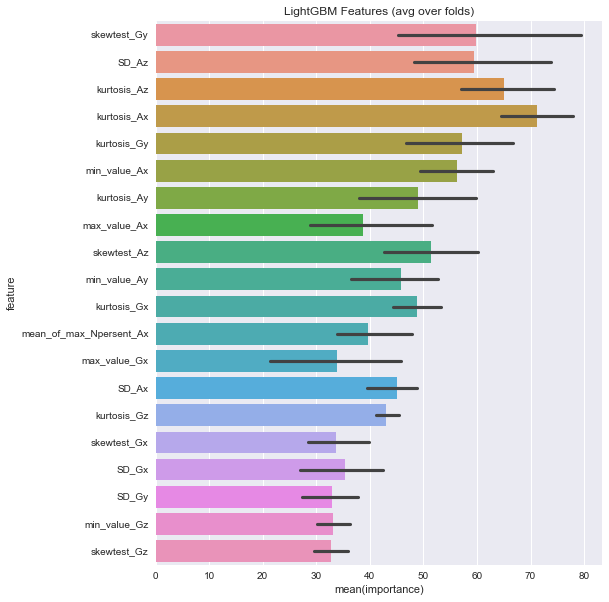

The dataset is from file: ManualExtractionData/IMUZRight. The action is: Walk_1
Fold  1 AUC : 0.626924
Fold  1 ACCURACY : 0.594771
******************************************
Fold  2 AUC : 0.610902
Fold  2 ACCURACY : 0.562092
******************************************
Fold  3 AUC : 0.715637
Fold  3 ACCURACY : 0.647059
******************************************
Fold  4 AUC : 0.592976
Fold  4 ACCURACY : 0.546053
******************************************
Fold  5 AUC : 0.735734
Fold  5 ACCURACY : 0.572368
******************************************
Full AUC score 0.644038
Full ACCURACY score 0.584535


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


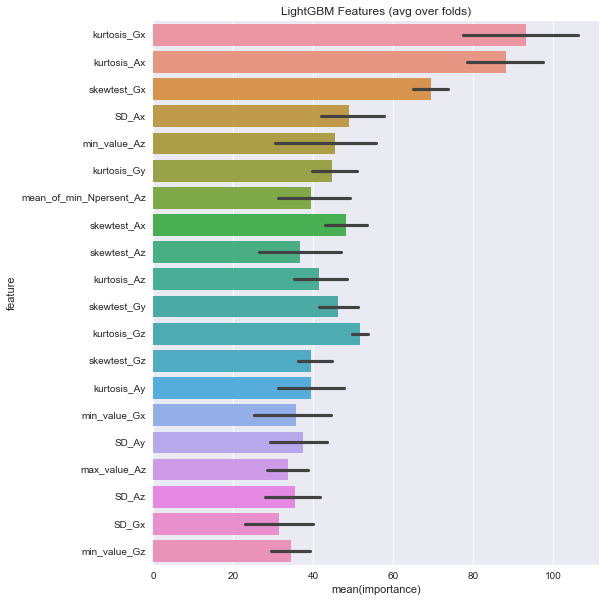

The dataset is from file: ManualExtractionData/IMUZRight. The action is: Walk_2
Fold  1 AUC : 0.641721
Fold  1 ACCURACY : 0.620915
******************************************
Fold  2 AUC : 0.610048
Fold  2 ACCURACY : 0.562092
******************************************
Fold  3 AUC : 0.662964
Fold  3 ACCURACY : 0.594771
******************************************
Fold  4 AUC : 0.625461
Fold  4 ACCURACY : 0.519737
******************************************
Fold  5 AUC : 0.754848
Fold  5 ACCURACY : 0.710526
******************************************
Full AUC score 0.641335
Full ACCURACY score 0.601573


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


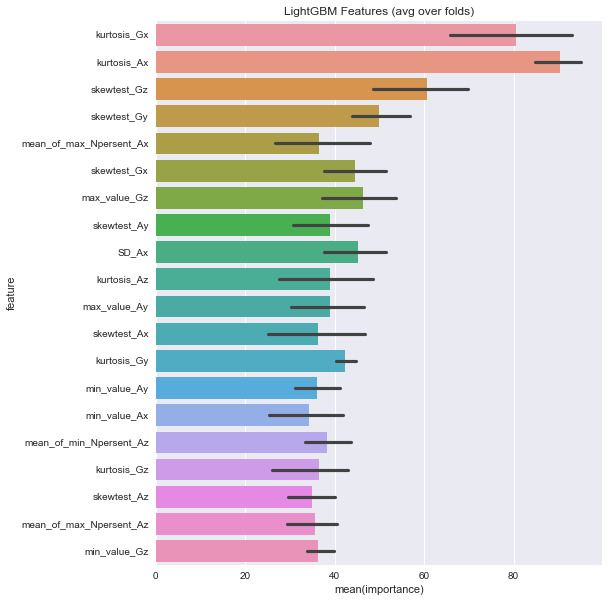

The dataset is from file: ManualExtractionData/IMUZRight. The action is: SlopeDown
Fold  1 AUC : 0.657886
Fold  1 ACCURACY : 0.620915
******************************************
Fold  2 AUC : 0.585441
Fold  2 ACCURACY : 0.535948
******************************************
Fold  3 AUC : 0.656890
Fold  3 ACCURACY : 0.594771
******************************************
Fold  4 AUC : 0.712730
Fold  4 ACCURACY : 0.651316
******************************************
Fold  5 AUC : 0.689012
Fold  5 ACCURACY : 0.585526
******************************************
Full AUC score 0.660311
Full ACCURACY score 0.597641


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


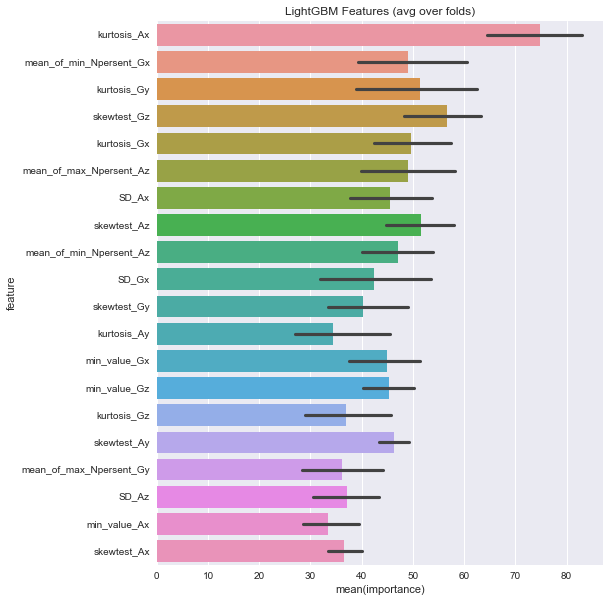

The dataset is from file: ManualExtractionData/IMUZRight. The action is: SlopeUp
Fold  1 AUC : 0.638813
Fold  1 ACCURACY : 0.620915
******************************************
Fold  2 AUC : 0.576384
Fold  2 ACCURACY : 0.542484
******************************************
Fold  3 AUC : 0.589032
Fold  3 ACCURACY : 0.568627
******************************************
Fold  4 AUC : 0.643284
Fold  4 ACCURACY : 0.585526
******************************************
Fold  5 AUC : 0.660665
Fold  5 ACCURACY : 0.644737
******************************************
Full AUC score 0.602988
Full ACCURACY score 0.592398


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


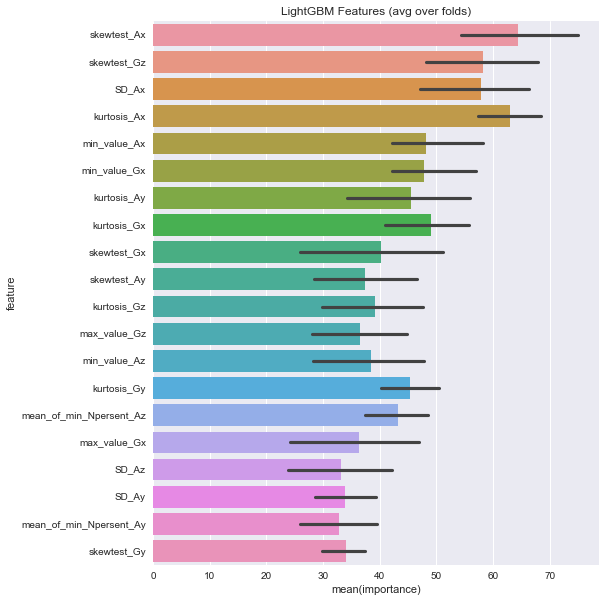

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: Walk_1
Fold  1 AUC : 0.615977
Fold  1 ACCURACY : 0.594771
******************************************
Fold  2 AUC : 0.559467
Fold  2 ACCURACY : 0.522876
******************************************
Fold  3 AUC : 0.610205
Fold  3 ACCURACY : 0.568627
******************************************
Fold  4 AUC : 0.606936
Fold  4 ACCURACY : 0.506579
******************************************
Fold  5 AUC : 0.650970
Fold  5 ACCURACY : 0.546053
******************************************
Full AUC score 0.595572
Full ACCURACY score 0.547837


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


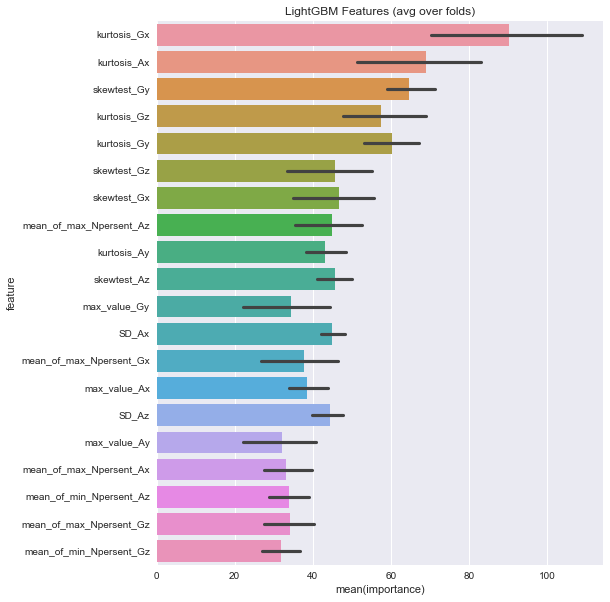

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: Walk_2
Fold  1 AUC : 0.628293
Fold  1 ACCURACY : 0.594771
******************************************
Fold  2 AUC : 0.537936
Fold  2 ACCURACY : 0.509804
******************************************
Fold  3 AUC : 0.667824
Fold  3 ACCURACY : 0.588235
******************************************
Fold  4 AUC : 0.654609
Fold  4 ACCURACY : 0.565789
******************************************
Fold  5 AUC : 0.698800
Fold  5 ACCURACY : 0.572368
******************************************
Full AUC score 0.631909
Full ACCURACY score 0.566186


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


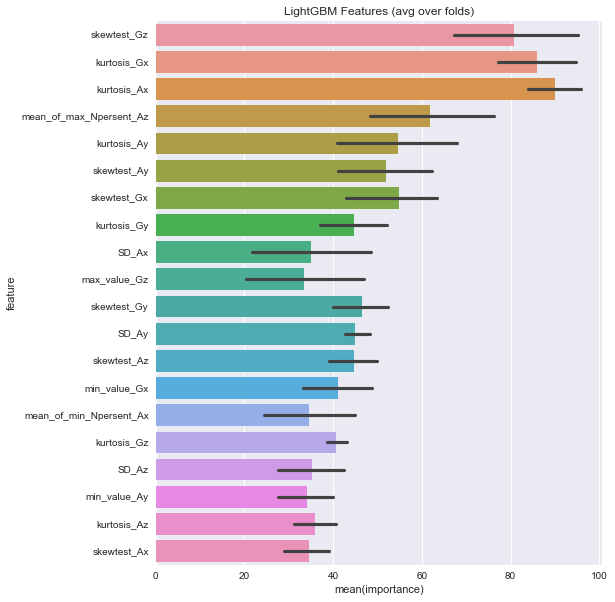

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: SlopeDown
Fold  1 AUC : 0.598529
Fold  1 ACCURACY : 0.581699
******************************************
Fold  2 AUC : 0.567925
Fold  2 ACCURACY : 0.555556
******************************************
Fold  3 AUC : 0.595279
Fold  3 ACCURACY : 0.549020
******************************************
Fold  4 AUC : 0.685162
Fold  4 ACCURACY : 0.611842
******************************************
Fold  5 AUC : 0.718467
Fold  5 ACCURACY : 0.710526
******************************************
Full AUC score 0.630429
Full ACCURACY score 0.601573


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


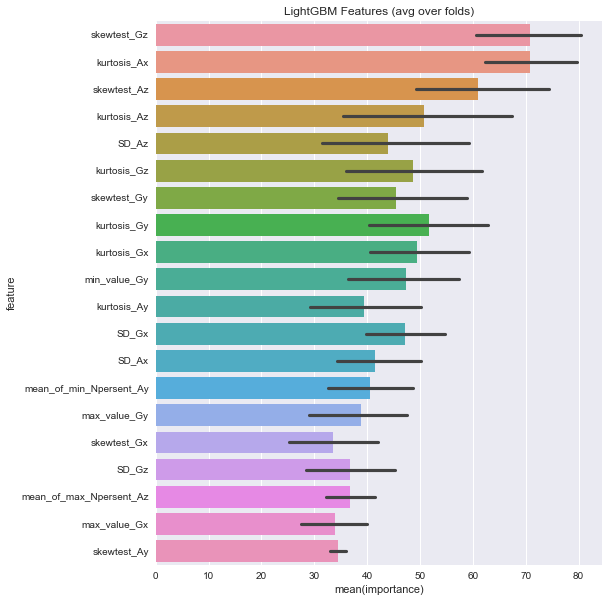

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: SlopeUp
Fold  1 AUC : 0.535751
Fold  1 ACCURACY : 0.535948
******************************************
Fold  2 AUC : 0.522556
Fold  2 ACCURACY : 0.516340
******************************************
Fold  3 AUC : 0.577230
Fold  3 ACCURACY : 0.549020
******************************************
Fold  4 AUC : 0.516681
Fold  4 ACCURACY : 0.493421
******************************************
Fold  5 AUC : 0.643029
Fold  5 ACCURACY : 0.611842
******************************************
Full AUC score 0.542548
Full ACCURACY score 0.541284


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


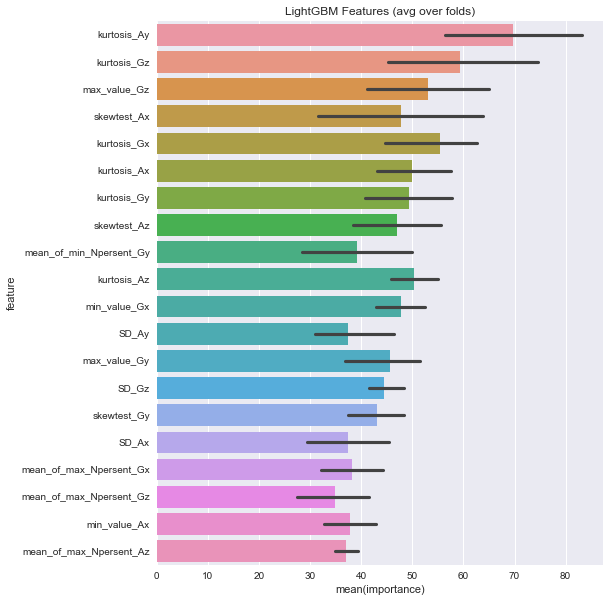

The dataset is from file: ManualExtractionData/Android. The action is: Walk_1
Fold  1 AUC : 0.595963
Fold  1 ACCURACY : 0.529412
******************************************
Fold  2 AUC : 0.487184
Fold  2 ACCURACY : 0.490196
******************************************
Fold  3 AUC : 0.576970
Fold  3 ACCURACY : 0.549020
******************************************
Fold  4 AUC : 0.638279
Fold  4 ACCURACY : 0.592105
******************************************
Fold  5 AUC : 0.622161
Fold  5 ACCURACY : 0.539474
******************************************
Full AUC score 0.576045
Full ACCURACY score 0.539974


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


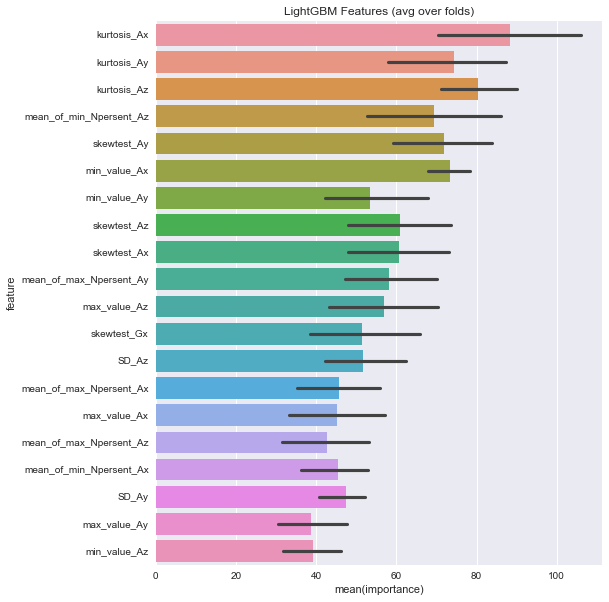

The dataset is from file: ManualExtractionData/Android. The action is: Walk_2
Fold  1 AUC : 0.597845
Fold  1 ACCURACY : 0.529412
******************************************
Fold  2 AUC : 0.500000
Fold  2 ACCURACY : 0.496732
******************************************
Fold  3 AUC : 0.624523
Fold  3 ACCURACY : 0.575163
******************************************
Fold  4 AUC : 0.637489
Fold  4 ACCURACY : 0.546053
******************************************
Fold  5 AUC : 0.653924
Fold  5 ACCURACY : 0.546053
******************************************
Full AUC score 0.586659
Full ACCURACY score 0.538663


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


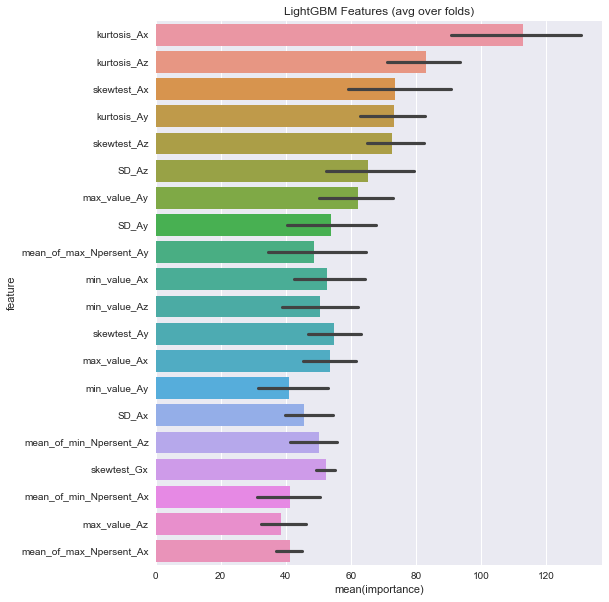

The dataset is from file: ManualExtractionData/Android. The action is: SlopeDown
Fold  1 AUC : 0.555080
Fold  1 ACCURACY : 0.503268
******************************************
Fold  2 AUC : 0.500171
Fold  2 ACCURACY : 0.496732
******************************************
Fold  3 AUC : 0.611159
Fold  3 ACCURACY : 0.562092
******************************************
Fold  4 AUC : 0.701141
Fold  4 ACCURACY : 0.598684
******************************************
Fold  5 AUC : 0.523730
Fold  5 ACCURACY : 0.467105
******************************************
Full AUC score 0.568864
Full ACCURACY score 0.525557


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


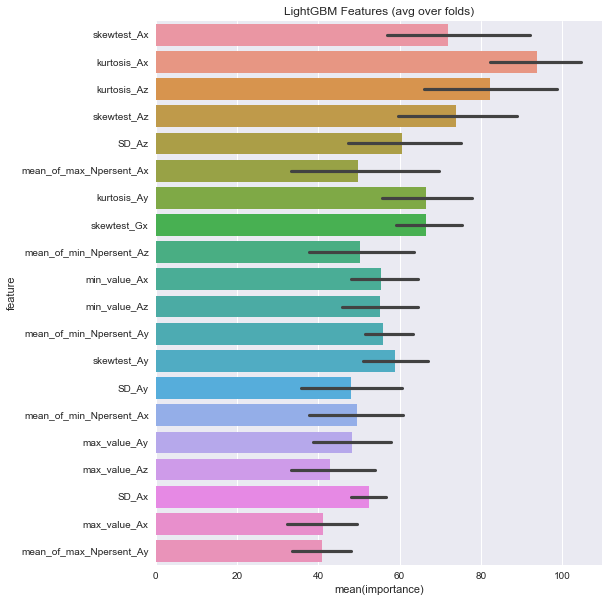

The dataset is from file: ManualExtractionData/Android. The action is: SlopeUp
Fold  1 AUC : 0.580226
Fold  1 ACCURACY : 0.529412
******************************************
Fold  2 AUC : 0.500000
Fold  2 ACCURACY : 0.496732
******************************************
Fold  3 AUC : 0.626258
Fold  3 ACCURACY : 0.607843
******************************************
Fold  4 AUC : 0.619315
Fold  4 ACCURACY : 0.546053
******************************************
Fold  5 AUC : 0.619114
Fold  5 ACCURACY : 0.526316
******************************************
Full AUC score 0.578142
Full ACCURACY score 0.541284


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


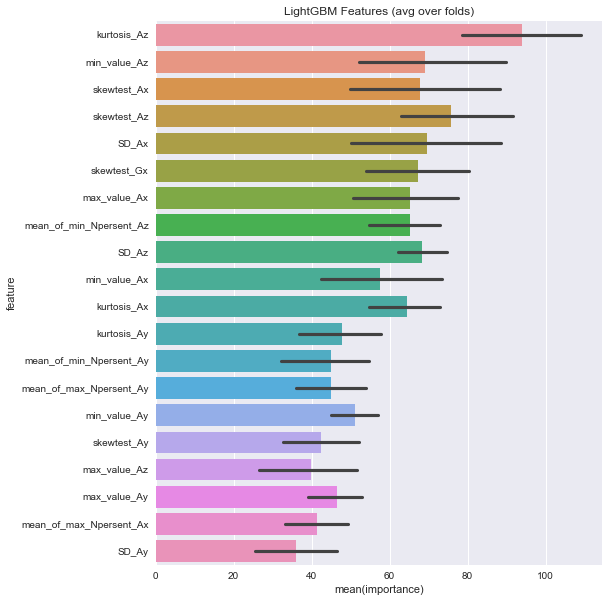

In [24]:
prediction(ID_list,label,file_name,action_name)